# Kaggle - Natural Language Processing with Disaster Tweets
### Predict which Tweets are about real disasters and which ones are not
https://www.kaggle.com/competitions/nlp-getting-started/overview

In [794]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers as ppb 
import matplotlib.pyplot as plt
import os
import re
from tensorflow import keras
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


In [795]:
# load data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [796]:
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [797]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [798]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Keyword

In [799]:
df_train.groupby(["keyword"]).describe()

id                                              \
                    count          mean        std      min       25%   
keyword                                                                 
ablaze               36.0     70.388889  14.035216     48.0     58.50   
accident             35.0    121.800000  15.118746     96.0    109.50   
aftershock           34.0    171.323529  13.975564    146.0    160.25   
airplane%20accident  35.0    220.142857  15.406536    196.0    208.50   
ambulance            38.0    269.052632  14.101845    246.0    258.50   
...                   ...           ...        ...      ...       ...   
wounded              37.0  10609.135135  14.491688  10585.0  10598.00   
wounds               33.0  10662.393939  14.225724  10636.0  10651.00   
wreck                37.0  10708.513514  15.230856  10685.0  10695.00   
wreckage             39.0  10759.717949  14.730828  10735.0  10747.50   
wrecked              39.0  10810.692308  15.178159  10785.0  10798.50   

                                                target                      \
                         50%       75%      max  count      mean       std   
keyword                                                                      
ablaze                  69.5     81.25     95.0   36.0  0.361111  0.487136   
accident               121.0    134.50    145.0   35.0  0.685714  0.471008   
aftershock             171.5    182.75    195.0   34.0  0.000000  0.000000   
airplane%20accident    219.0    233.50    245.0   35.0  0.857143  0.355036   
ambulance              268.5    279.75    294.0   38.0  0.526316  0.506009   
...                      ...       ...      ...    ...       ...       ...   
wounded              10609.0  10622.00  10632.0   37.0  0.702703  0.463373   
wounds               10663.0  10675.00  10684.0   33.0  0.303030  0.466694   
wreck                10708.0  10722.00  10733.0   37.0  0.189189  0.397061   
wreckage             10760.0  10771.50  10784.0   39.0  1.000000  0.000000   
wrecked              10812.0  10823.50  10834.0   39.0  0.076923  0.269953   

                                              
                     min  25%  50%  75%  max  
keyword                                       
ablaze               0.0  0.0  0.0  1.0  1.0  
accident             0.0  0.0  1.0  1.0  1.0  
aftershock           0.0  0.0  0.0  0.0  0.0  
airplane%20accident  0.0  1.0  1.0  1.0  1.0  
ambulance            0.0  0.0  1.0  1.0  1.0  
...                  ...  ...  ...  ...  ...  
wounded              0.0  0.0  1.0  1.0  1.0  
wounds               0.0  0.0  0.0  1.0  1.0  
wreck                0.0  0.0  0.0  0.0  1.0  
wreckage             1.0  1.0  1.0  1.0  1.0  
wrecked              0.0  0.0  0.0  0.0  1.0  

[221 rows x 16 columns]

In [800]:
df_train.groupby(["keyword"])["keyword"].count()

keyword
ablaze                 36
accident               35
aftershock             34
airplane%20accident    35
ambulance              38
                       ..
wounded                37
wounds                 33
wreck                  37
wreckage               39
wrecked                39
Name: keyword, Length: 221, dtype: int64

In [801]:
df_test.groupby(["keyword"]).describe()

id                                                      \
                    count          mean        std      min      25%      50%   
keyword                                                                         
ablaze               14.0     70.785714  16.446550     46.0     58.5     71.0   
accident             15.0    117.466667  13.211827     99.0    107.0    116.0   
aftershock           16.0    168.750000  16.114176    147.0    153.5    168.0   
airplane%20accident  15.0    221.333333  12.893335    200.0    210.5    224.0   
ambulance            12.0    275.083333  15.733337    250.0    258.5    280.0   
...                   ...           ...        ...      ...      ...      ...   
wounded              13.0  10610.538462  15.365629  10586.0  10597.0  10614.0   
wounds               17.0  10653.882353  13.972662  10635.0  10643.0  10652.0   
wreck                13.0  10712.307692  12.658229  10694.0  10701.0  10714.0   
wreckage             11.0  10758.727273  14.690752  10738.0  10749.0  10758.0   
wrecked              11.0  10805.272727  11.858254  10791.0  10796.5  10804.0   

                                        
                          75%      max  
keyword                                 
ablaze                  86.25     94.0  
accident               124.50    142.0  
aftershock             182.25    192.0  
airplane%20accident    231.50    239.0  
ambulance              286.50    295.0  
...                       ...      ...  
wounded              10619.00  10634.0  
wounds               10664.00  10683.0  
wreck                10719.00  10734.0  
wreckage             10767.50  10781.0  
wrecked              10811.50  10828.0  

[221 rows x 8 columns]

In [802]:
df_train.groupby(["keyword", "target"])["keyword"].count()

keyword     target
ablaze      0         23
            1         13
accident    0         11
            1         24
aftershock  0         34
                      ..
wreck       0         30
            1          7
wreckage    1         39
wrecked     0         36
            1          3
Name: keyword, Length: 438, dtype: int64

### Data pre-processing

In [803]:
# fill empty cell
df_train = df_train.fillna("none")
df_test = df_test.fillna("none")

In [804]:
df_train.head()

,id,keyword,location,text,target
0,1,none,none,Our Deeds are the Reason of this #earthquake M...,1
1,4,none,none,Forest fire near La Ronge Sask. Canada,1
2,5,none,none,All residents asked to 'shelter in place' are ...,1
3,6,none,none,"13,000 people receive #wildfires evacuation or...",1
4,7,none,none,Just got sent this photo from Ruby #Alaska as ...,1


In [805]:
# concat keywords and text
df_train["text"]  = 'keyword: ' + df_train["keyword"] + ' - ' + df_train["text"]
df_test["text"]  = 'keyword: ' + df_test["keyword"] + ' - ' + df_test["text"]

In [806]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [807]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

In [808]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text) # no emoji

In [809]:
df_train['text'] = df_train['text'].apply(remove_url).apply(remove_html).apply(remove_emoji)
df_test['text'] = df_test['text'].apply(remove_url).apply(remove_html).apply(remove_emoji)

In [810]:
df_train.iloc[50:70,:]

,id,keyword,location,text,target
50,73,ablaze,"Sheffield Township, Ohio",keyword: ablaze - Deputies: Man shot before Br...,1
51,74,ablaze,India,keyword: ablaze - Man wife get six years jail ...,1
52,76,ablaze,Barbados,keyword: ablaze - SANTA CRUZ ÛÓ Head of the S...,0
53,77,ablaze,Anaheim,keyword: ablaze - Police: Arsonist Deliberatel...,1
54,78,ablaze,Abuja,keyword: ablaze - Noches El-Bestia '@Alexis_Sa...,0
55,79,ablaze,USA,keyword: ablaze - #Kurds trampling on Turkmen ...,1
56,80,ablaze,South Africa,keyword: ablaze - TRUCK ABLAZE : R21. VOORTREK...,1
57,81,ablaze,"Sao Paulo, Brazil",keyword: ablaze - Set our hearts ablaze and ev...,0
58,82,ablaze,hollywoodland,keyword: ablaze - They sky was ablaze tonight ...,0
59,83,ablaze,"Edmonton, Alberta - Treaty 6",keyword: ablaze - How the West was burned: Tho...,1


### Text

In [811]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      108.022068
std        33.249476
min        24.000000
25%        83.000000
50%       110.000000
75%       135.000000
max       175.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      109.040147
std        33.442043
min        22.000000
25%        84.000000
50%       112.000000
75%       135.500000
max       182.000000
Name: length, dtype: float64


### Target

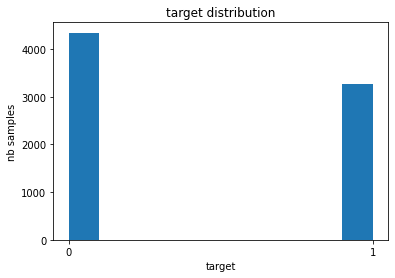

In [812]:
labels = df_train["target"]
plt.hist(labels)
plt.xlabel('target')
plt.ylabel('nb samples')
plt.title('target distribution')
plt.xticks(np.arange(len(np.unique(labels))));

### Loading the Pre-trained BERT model

In [813]:
model_class, tokenizer_class, pretrained_weights = (ppb.TFDistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [814]:
model.summary()

Model: "tf_distil_bert_model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
Total params: 66,362,880
Trainable params: 66,362,880
Non-trainable params: 0
_________________________________________________________________


### Tokenization

In [815]:
def tokenize(sentences):
    tokenized = [tokenizer(sentence, add_special_tokens=True)['input_ids'] for sentence in sentences]
    return tokenized

In [816]:
tokenized = tokenize(df_train["text"])

In [817]:
print("sentence: ", df_train["text"][0] )
print("tokenized: ", tokenized[0])
print("decoded: ", tokenizer.decode(tokenized[0]))

sentence:  keyword: none - Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
tokenized:  [101, 3145, 18351, 1024, 3904, 1011, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035, 102]
decoded:  [CLS] keyword : none - our deeds are the reason of this # earthquake may allah forgive us all [SEP]


### Padding

In [818]:
# get the maxh length
max_len = max(df_train["length"].max(), df_test["length"].max())
print("Max sentence length is ", max_len)

Max sentence length is  182


In [819]:
def pad_tokens(tokens, max_len):
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokens])
    return padded

In [820]:
padded = pad_tokens(tokenized, max_len)
print(padded[0])

[  101  3145 18351  1024  3904  1011  2256 15616  2024  1996  3114  1997
  2023  1001  8372  2089 16455  9641  2149  2035   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [821]:
print("shape of padded: ", padded.shape)

shape of padded:  (7613, 182)


### Masking

In [822]:
def get_attention_mask(tokens):
    attention_mask = np.where(tokens != 0, 1, 0)    
    return attention_mask

In [823]:
attention_mask = get_attention_mask(padded)
print(attention_mask[0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [824]:
print("shape of attention mask: ", attention_mask.shape)

shape of attention mask:  (7613, 182)


### Create input tensor

In [825]:
input_ids = tf.convert_to_tensor(padded, dtype=tf.int32)
attention_mask = tf.convert_to_tensor(attention_mask, dtype=tf.int32)

### Extract feature vectors
The model() function runs our sentences through BERT. The results of the processing will be returned into last_hidden_states.

In [826]:
def extract_features(input_ids, attention_mask):
    batch_size = 200
    m = input_ids.shape[0]
    n = int(m / batch_size)

    hidden_units =  model.config.to_dict()['dim']
    features = np.zeros((m, hidden_units))

    print('Extract features using batches for memory issue:')

    for i in range(n):
        j, k = i*batch_size, i*batch_size+batch_size
        print(f'Batch {i+1} [{j}:{k}]')
        batch_input = input_ids[j:k]
        batch_attention_mask = attention_mask[j:k]
        last_hidden_states = model(batch_input, attention_mask = batch_attention_mask)

        # Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. 
        # The way BERT does sentence classification, is that it adds a token called [CLS] (for classification) at the beginning of 
        # every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.
        features[j:k] = last_hidden_states[0][:,0,:].numpy()

        ## if you use BERT instead of distilBERT model, use this
        #features[j:k] = last_hidden_states[1].numpy() 

    if(n*batch_size != m):
        i = i + 1
        j, k = i*batch_size, i*batch_size+(m-n*batch_size)
        print(f'Batch {i+1} [{j}:{k}]')
        batch_input = input_ids[j:k]
        batch_attention_mask = attention_mask[j:k]
        last_hidden_states = model(batch_input, attention_mask = batch_attention_mask)
        features[j:k] = last_hidden_states[0][:,0,:].numpy()

    return features

In [827]:
def get_features(input_ids, attention_mask, filename):
    if os.path.exists(filename):
        F = np.load(filename)
    else:
        F = extract_features(input_ids, attention_mask)
        np.save(filename, F)
    return F

In [828]:
features = get_features(input_ids, attention_mask, "data/E3_train.npy")
print("shape of feature vectors: ", features.shape)

shape of feature vectors:  (7613, 768)


### Extract Labels

In [829]:
lables = df_train["target"].to_numpy()
print("shape of feature labels: ", labels.shape)

shape of feature labels:  (7613,)


### Train/Validation split

In [830]:
# 80% train, 20% validation
split_size = int(features.shape[0] * .99)    
X_train = features[:split_size,:]
Y_train = lables[:split_size]
X_val = features[split_size:,:]
Y_val = lables[split_size:]

print("shapes of training data: ", X_train.shape, Y_train.shape)
print("shapes of validation data: ", X_val.shape, Y_val.shape)

shapes of training data:  (7536, 768) (7536,)
shapes of validation data:  (77, 768) (77,)


### Create the Logistic Regression Model

In [831]:
def create_model(input_shape, classes):
    inputs = keras.Input(shape=input_shape, name='input')
    outputs = keras.layers.Dense(classes, activation='sigmoid', name='output')(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adamax()

    model.compile(
        loss='binary_crossentropy', 
        optimizer=optimizer, 
        metrics=['binary_accuracy']
    )

    return model

In [832]:
lr_model = create_model(X_train.shape[1], 1)
lr_model.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 768)]             0         
_________________________________________________________________
output (Dense)               (None, 1)                 769       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


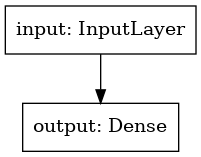

In [833]:
keras.utils.plot_model(lr_model)

### Train the model

In [834]:
history = lr_model.fit(
    X_train,
    Y_train,
    epochs=400,
    batch_size=128,
    validation_split=0.05,
    verbose=1
)

Epoch 1/400
56/56 [==============================] - 1s 3ms/step - loss: 0.6442 - binary_accuracy: 0.6462 - val_loss: 0.6053 - val_binary_accuracy: 0.7613
Epoch 2/400
56/56 [==============================] - 0s 1ms/step - loss: 0.5727 - binary_accuracy: 0.7540 - val_loss: 0.5535 - val_binary_accuracy: 0.7666
Epoch 3/400
56/56 [==============================] - 0s 1ms/step - loss: 0.5347 - binary_accuracy: 0.7741 - val_loss: 0.5205 - val_binary_accuracy: 0.7692
Epoch 4/400
56/56 [==============================] - 0s 1ms/step - loss: 0.5111 - binary_accuracy: 0.7808 - val_loss: 0.4955 - val_binary_accuracy: 0.7798
Epoch 5/400
56/56 [==============================] - 0s 1ms/step - loss: 0.4953 - binary_accuracy: 0.7824 - val_loss: 0.4801 - val_binary_accuracy: 0.7772
Epoch 6/400
56/56 [==============================] - 0s 1ms/step - loss: 0.4842 - binary_accuracy: 0.7882 - val_loss: 0.4750 - val_binary_accuracy: 0.7798
Epoch 7/400
56/56 [==============================] - 0s 1ms/step - los

56/56 [==============================] - 0s 2ms/step - loss: 0.4361 - binary_accuracy: 0.8051 - val_loss: 0.4320 - val_binary_accuracy: 0.7931
Epoch 18/400
56/56 [==============================] - 0s 1ms/step - loss: 0.4341 - binary_accuracy: 0.8053 - val_loss: 0.4310 - val_binary_accuracy: 0.8064
Epoch 19/400
56/56 [==============================] - 0s 2ms/step - loss: 0.4328 - binary_accuracy: 0.8096 - val_loss: 0.4298 - val_binary_accuracy: 0.8037
Epoch 20/400
56/56 [==============================] - 0s 1ms/step - loss: 0.4311 - binary_accuracy: 0.8081 - val_loss: 0.4307 - val_binary_accuracy: 0.8037
Epoch 21/400
56/56 [==============================] - 0s 1ms/step - loss: 0.4296 - binary_accuracy: 0.8088 - val_loss: 0.4248 - val_binary_accuracy: 0.7958
Epoch 22/400
56/56 [==============================] - 0s 1ms/step - loss: 0.4290 - binary_accuracy: 0.8093 - val_loss: 0.4250 - val_binary_accuracy: 0.7984
Epoch 23/400
56/56 [==============================] - 0s 2ms/step - loss: 0.4

In [835]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.tail()

,loss,binary_accuracy,val_loss,val_binary_accuracy,epoch
395,0.377384,0.837128,0.414007,0.824934,395
396,0.377445,0.836290,0.411233,0.819629,396
397,0.376605,0.837128,0.413505,0.824934,397
398,0.376788,0.836150,0.411200,0.819629,398
399,0.376967,0.836709,0.411701,0.822281,399


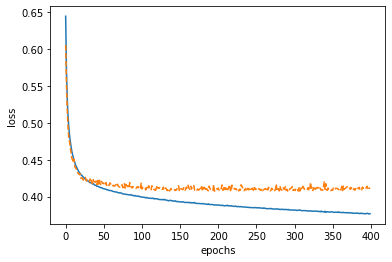

In [836]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(history_df['epoch'], history_df['loss'], label='Training')
plt.plot(history_df['epoch'], history_df['val_loss'], label='Validation', linestyle='dashed')

### Model Evaluation

In [837]:
lr_model.evaluate(X_val, Y_val)

3/3 [==============================] - 0s 2ms/step - loss: 0.2280 - binary_accuracy: 0.9221


[0.228025883436203, 0.9220778942108154]

In [838]:
pred = lr_model.predict(X_val)
pred = pred > .5
pred =(pred[:,0]).astype(int)


In [839]:
tp = np.logical_and(pred == 1, Y_val == 1).sum()  # true positive
tn = np.logical_and(pred == 0, Y_val == 0).sum()  # true negative
fp = np.logical_and(pred == 1, Y_val == 0).sum()  # false positive
fn = np.logical_and(pred == 0, Y_val == 1).sum()  # false negative

precision = tp/(tp+fp)
recall = tp/(tp+fn)

f1_score = 2*(precision*recall)/(precision+recall)

print("True Positive: ", tp)
print("True Negative: ", tn)
print("False Positive: ", fp)
print("false Negative: ", fn)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)


True Positive:  33
True Negative:  38
False Positive:  1
false Negative:  5
Precision:  0.9705882352941176
Recall:  0.868421052631579
F1 Score:  0.9166666666666667


In [840]:
def displayConfusionMatrix(y_test, pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        pred,
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

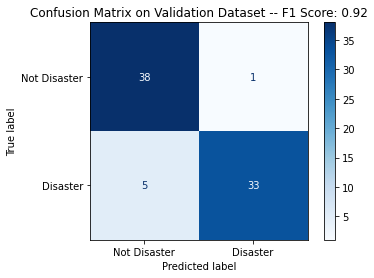

In [841]:
displayConfusionMatrix(Y_val, pred, "Validation")

### Inference

In [842]:
test_tokenized = tokenize(df_test["text"])
test_padded = pad_tokens(test_tokenized, max_len)
print("shape of test_padded: ", test_padded.shape)

shape of test_padded:  (3263, 182)


In [843]:
test_attention_mask = get_attention_mask(test_padded)
print("shape of test attention mask: ", test_attention_mask.shape)

shape of test attention mask:  (3263, 182)


In [844]:
test_input_ids = tf.convert_to_tensor(test_padded, dtype=tf.int32)
test_attention_mask = tf.convert_to_tensor(test_attention_mask, dtype=tf.int32)

In [845]:
test_features = get_features(test_input_ids, test_attention_mask, "data/E3_test.npy")
print("shape of test_feature vectors: ", test_features.shape)

shape of test_feature vectors:  (3263, 768)


In [846]:
X_test = test_features

In [847]:
pred_test = lr_model.predict(X_test)
pred_test = pred_test > .5
pred_test =(pred_test[:,0]).astype(int)

In [848]:
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [849]:
sample_submission["target"] = pred_test
sample_submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [850]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.381244
std,3146.427221,0.485767
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [851]:
sample_submission.to_csv("data/submission3.csv", index=False)